# Proyecto final de Inteligencia Artificial
---
Cambio sobre el código original para predecir número de casos por día.

Estudiantes:

*   Marcos Ibañez - maibanez@fiuna.edu.py
*   Hugo Melgarejo - hmelgarejo@fiuna.edu.py

Docentes:

*   Profesor Encargado - Dr. Diego Stalder - stalderdiego@gmail.com 
*   Profesor Auxiliar - Ing. Enrique Paiva - epaiva@fiuna.edu.py

In [178]:
#Importamos las librerias necesarias
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
import plotly.graph_objects as go


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



# Inicio del preprocesamiento de datos

## Importamos la base del MSPBS de Paraguay
La base de datos inicia el recuento de casos por país el 7 de marzo del año 2020 y se va actualizando hasta la fecha.

In [179]:
#Importamos la base de datos de la universidad Johns Hopkins
url = 'https://raw.githubusercontent.com/MarcScript/COVID-19-Paraguay-Cases-Prediction-with-Neural-LSTM-Network-/main/REGISTRO_DIARIO_Full_Data_data.csv'
ds = pd.read_csv(url)
ds.tail()


,Fecha,Day of Max.Fecha,Max.Fecha,Cantidad Descartada,Cantidad Pruebas,Confirmados en albergues,Confirmados Total,Datos Internados,Fallecidos,Internados Generales,Internados UTI,Number of Records,Recuperados
467,6/17/2021,"June 21, 2021",6/21/2021,6235,8717,5,2482,3846.0,113,3249,597,1,2724
468,6/18/2021,"June 21, 2021",6/21/2021,6497,8646,3,2149,3777.0,117,3214,563,1,2699
469,6/19/2021,"June 21, 2021",6/21/2021,6508,8191,0,1683,3785.0,110,3213,572,1,2708
470,6/20/2021,"June 21, 2021",6/21/2021,6097,7242,0,1145,3721.0,112,3150,571,1,2695
471,6/21/2021,"June 21, 2021",6/21/2021,5020,6521,0,1501,3720.0,110,3143,577,1,2687


In [180]:
#Extraemos los parámetros que nos interesan
fechas = ds.iloc[:,0]
fechas = fechas.iloc[300:473]
casos = ds.iloc[:,6]
casos = casos.iloc[300:473]
print(casos)
print(fechas)
fechas.head()
casos.head()
diccionario = {'Fecha':fechas,'Casos por día':casos}
dataset = pd.DataFrame(data=diccionario)
dataset.set_index('Fecha')


300     417
301     369
302     355
303     764
304     959
       ... 
467    2482
468    2149
469    1683
470    1145
471    1501
Name: Confirmados Total, Length: 172, dtype: int64
300     1/1/2021
301     1/2/2021
302     1/3/2021
303     1/4/2021
304     1/5/2021
         ...    
467    6/17/2021
468    6/18/2021
469    6/19/2021
470    6/20/2021
471    6/21/2021
Name: Fecha, Length: 172, dtype: object


,Casos por día
Fecha,
1/1/2021,417
1/2/2021,369
1/3/2021,355
1/4/2021,764
1/5/2021,959
...,...
6/17/2021,2482
6/18/2021,2149
6/19/2021,1683


In [181]:
#Transponemos los datos para que quede una serie temporal
serie_temporal = dataset[['Casos por día']].values
# Normalizamos el dataset para disminuir el error
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(serie_temporal)
index = fechas
Y = scaler.inverse_transform(X)


## Gráfico de situación actual.

In [182]:
# Using plotly.express
import plotly.express as px
df = dataset
fig = px.line(df, x='Fecha', y="Casos por día")
fig.show()

## Separamos los datos en conjunto de entrenamiento y test

In [183]:
split_percent = 0.80
split = int(split_percent*len(X))

train = X[:split]
test = X[split:]
date_train, date_test =  index[:split], index[split:]


In [201]:
#Problema a solucionar, hacer que look_back sea mayor en el aprendizaje
# Realizamos reshape como X=t y Y=t+1
look_back = 1
train_generator = TimeseriesGenerator(train,train,length = look_back,batch_size=1)
test_generator = TimeseriesGenerator(test, test, length=look_back, batch_size=1)


# Creamos y entrenamos la red neuronal recurrente LSTM

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


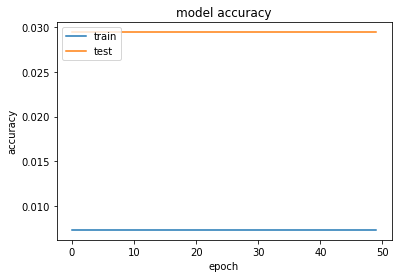

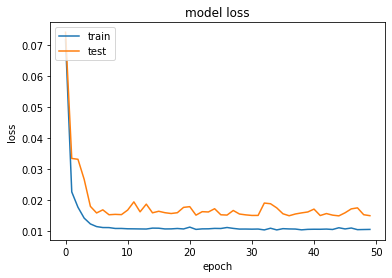

In [185]:
# Creamos la red neuronal LSTM
import matplotlib.pyplot as plt
num_epochs = 50
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=["accuracy"])
H = model.fit(train_generator, epochs=num_epochs, verbose=0,validation_data=test_generator)
print(H.history.keys())
N = num_epochs
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



# Visualizamos la predicción realizada por el modelo

In [186]:
from sklearn.metrics import confusion_matrix, classification_report 
prediction = model.predict_generator(test_generator)


train = Y[:split]
test = Y[split:]
prediction = scaler.inverse_transform(prediction)
prediction = prediction.reshape((-1))
train = train.reshape((-1))
test = test.reshape((-1))
error = prediction - test[:-1]
print(model.summary())


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None


In [187]:
import plotly.graph_objects as go
trace1 = go.Scatter(
    x = date_train,
    y = train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predicción de casos diarios de COVID-19 en Paraguay",
    xaxis = {'title' : "Fecha"},
    yaxis = {'title' : "Nro. de casos confirmados"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()
#Limitar cantidad de días
#Histograma de error

# Forecasting

In [194]:

index = np.array(index)
close_data = np.array(index)
close_data = close_data.reshape((-1,1))
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = X[-look_back:]
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    #last_date = df['Date'].values[-1]
    last_date = index[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1)
    return prediction_dates

num_prediction = 2
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

forecast_dates = forecast_dates.strftime("%x")
#.tolist()
print(forecast_dates)
forecast = forecast.reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
forecast = forecast.reshape((-1))
print(forecast)

Index(['06/21/21', '06/22/21', '06/23/21'], dtype='object')
[1501.         1561.14673597 1614.52822357]


In [203]:
trace1 = go.Scatter(
    x = date_train,
    y = train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = test,
    mode='lines',
    name = 'Ground Truth'
)
trace4 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode='lines',
    name = 'Future prediction'
)
layout = go.Layout(
    title = "Predicción de casos diarios de COVID-19 en Paraguay en 2021",
    xaxis = {'title' : "Fecha"},
    yaxis = {'title' : "Nro. de casos confirmados"}
)
fig = go.Figure(data=[trace1, trace2, trace3,trace4], layout=layout)
fig.show()


In [204]:

trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = test,
    mode='lines',
    name = 'Ground Truth'
)
trace4 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode='lines',
    name = 'Future prediction'
)
layout = go.Layout(
    title = "Predicción de casos diarios de COVID-19 en Paraguay en 2021",
    xaxis = {'title' : "Fecha"},
    yaxis = {'title' : "Nro. de casos confirmados por dia"}
)
fig = go.Figure(data=[trace2, trace3,trace4], layout=layout)
fig.show()

# Revisamos las métricas del modelo para corroborar su correcto desempeño

Calculamos el error por predicción y el error promedio
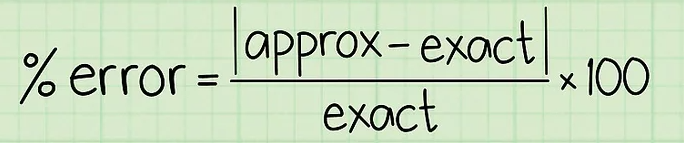

In [198]:
import plotly.graph_objects as go


layout = go.Layout(
    title = "Error diarío cometido por el modelo",
    xaxis = {'title' : "Fecha"},
    yaxis = {'title' : "Nro. de predicciones erroneas (Casos)"}
)
fig = go.Figure([go.Bar(x=date_test, y=error)], layout=layout)
fig.show()

In [191]:
error = prediction - test [:-1]
porcentaje = (abs(error)/test[:-1])*100

suma = 0
for valor in porcentaje:
    suma = suma + valor
porcentaje_prom = suma / len(porcentaje)
error_max = max(abs(error))
error_min = min(abs(error))
print("El porcentaje de error promedio del modelo es: {}\n".format(porcentaje_prom))
print("El máximo error cometido por el modelo fue de: {} personas por día\n".format(error_max))
print("El mínimo error cometido por el modelo fue de: {} personas por día\n".format(error_min))

El porcentaje de error promedio del modelo es: 3.075789529166091

El máximo error cometido por el modelo fue de: 177.00537109375 personas por día

El mínimo error cometido por el modelo fue de: 0.977783203125 personas por día



In [205]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
errors = {"Root Mean Squared ErrorNorm": [], "Mean Squared Error": [], "Root Mean Squared Error": [], "Mean Absolute Error": [], "R^2 Score": [], "Mean Absolute Percentual Error": [],"Min Absolute Percentual Error": [],"P25 Absolute Percentual Error": [],"Median Absolute Percentual Error": [],"P75 Absolute Percentual Error": [],"Max Absolute Percentual Error": []}
errors["Root Mean Squared ErrorNorm"].append(np.sqrt(mean_squared_error(test [:-1],prediction)))
errors["Mean Absolute Error"].append(mean_absolute_error(test [:-1], prediction))
errors["Mean Squared Error"].append(mean_squared_error(test [:-1], prediction))
errors["Root Mean Squared Error"].append(np.sqrt(mean_squared_error(test [:-1], prediction)))
errors["R^2 Score"].append(r2_score(test [:-1], prediction))
MAPE=np.abs((test [:-1] -prediction) /test [:-1]) * 100
errors["Mean Absolute Percentual Error"].append(np.mean(MAPE))
errors["Min Absolute Percentual Error"].append(np.min(MAPE))
errors["P25 Absolute Percentual Error"].append(np.percentile(MAPE,25))
errors["Median Absolute Percentual Error"].append(np.percentile(MAPE,50))
errors["P75 Absolute Percentual Error"].append(np.percentile(MAPE,75) )
errors["Max Absolute Percentual Error"].append(np.max(MAPE))

dictionary_items = errors.items()
for item in dictionary_items:
    print(item)


('Root Mean Squared ErrorNorm', [97.30836493076285])
('Mean Squared Error', [9468.917885498517])
('Root Mean Squared Error', [97.30836493076285])
('Mean Absolute Error', [85.00750014361209])
('R^2 Score', [0.9658772029171825])
('Mean Absolute Percentual Error', [3.075789529166091])
('Min Absolute Percentual Error', [0.04778999037756598])
('P25 Absolute Percentual Error', [2.2187858888384033])
('Median Absolute Percentual Error', [3.070453183350325])
('P75 Absolute Percentual Error', [4.1725758597033])
('Max Absolute Percentual Error', [8.796781181768559])


### Bibliografía


*  Predicción de series temporales utilizando redes LSTM [machinelearningmastery.com](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
*  Repositorio COVID-19 de la universidad John Hopckins
[CSSEGISandData](https://github.com/CSSEGISandData)
*   Repositorio COVID-19 del MSPBS de Paraguay [MSPBS](https://public.tableau.com/app/profile/mspbs/viz/COVID19PY-Registros/REGISTRODIARIO)



